In [16]:
# ===== IMPORTS =====
import pandas as pd                    # For data manipulation and analysis (DataFrame operations)
import numpy as np                     # For numerical operations and array handling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# train_test_split: Splits data into training and testing sets
# cross_val_score: Performs cross-validation scoring
# GridSearchCV: Searches for best parameters using cross-validation
from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay: Visualizes confusion matrix

from sklearn.tree import DecisionTreeClassifier          # Decision Tree model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# RandomForestClassifier: Ensemble of Decision Trees
# AdaBoostClassifier: Boosting algorithm

from sklearn.naive_bayes import GaussianNB              # Naive Bayes classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Accuracy: (TP+TN)/(TP+TN+FP+FN) - Overall correctness
# Precision: TP/(TP+FP) - How precise our positive predictions are
# Recall: TP/(TP+FN) - How many positives we correctly identify
# F1-Score: 2*(Precision*Recall)/(Precision+Recall) - Balance between precision and recall
# Confusion Matrix: Visual representation of predictions vs actual

import matplotlib.pyplot as plt       # For creating plots and visualizations
import seaborn as sns                 # For enhanced statistical visualizations
import warnings                       # To suppress warning messages
warnings.filterwarnings('ignore')     # Ignore warnings for cleaner output

In [17]:
# Load and Prepare Data
feature_columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                   'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
# Define the target variable column name
class_column = 'class'
# Combine feature columns and class column into one list
all_columns = feature_columns + [class_column]

# Load the dataset into a pandas DataFrame
data = pd.read_csv('magic04.data', names=all_columns)       

# Data Balancing: Downsample gamma class to match hadron class size
gammas = data[data['class'] == 'g']
hadrons = data[data['class'] == 'h']
gammas_sample = gammas.sample(n=len(hadrons), random_state=42)
balanced_data = pd.concat([gammas_sample, hadrons], ignore_index=True)

X = balanced_data.drop('class', axis=1)
y = balanced_data['class'].map({'g': 1, 'h': 0})

# Initialize dictionaries to store models and metrics
models = {}
metrics = {}

# Data Split: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Data loaded successfully!")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Class distribution in y_train: {y_train.value_counts().to_dict()}")

Data loaded successfully!
Training set size: (9363, 10)
Testing set size: (4013, 10)
Class distribution in y_train: {0: 4699, 1: 4664}


In [18]:
# Function to evaluate model performance        
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)
    return acc, prec, rec, f1, cm

# Helper function to store metrics
def store_metrics(name, y_true, y_pred):
    metrics[name] = {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall':    recall_score(y_true, y_pred, average='weighted'),
        'F1-score':  f1_score(y_true, y_pred, average='weighted')
    }

In [19]:
print("Training Decision Tree...")
# (a) Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt
store_metrics('Decision Tree', y_test, dt.predict(X_test))
evaluate_model(dt, "Decision Tree")

Training Decision Tree...
Decision Tree Metrics:
Accuracy: 0.7924
Precision: 0.7924
Recall: 0.7924
F1-Score: 0.7924
Confusion Matrix:
[[1561  428]
 [ 405 1619]]
--------------------------------------------------


(0.7924246199850485,
 0.7924422980235537,
 0.7924246199850485,
 0.7924074217420453,
 array([[1561,  428],
        [ 405, 1619]]))

In [20]:
print("Training Naïve Bayes...")
# (b) Naïve Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
models['Naive Bayes'] = nb
store_metrics('Naive Bayes', y_test, nb.predict(X_test))
evaluate_model(nb, "Naive Bayes")

Training Naïve Bayes...
Naive Bayes Metrics:
Accuracy: 0.6574
Precision: 0.7078
Recall: 0.6574
F1-Score: 0.6338
Confusion Matrix:
[[ 802 1187]
 [ 188 1836]]
--------------------------------------------------


(0.6573635684026913,
 0.7078381645841735,
 0.6573635684026913,
 0.6338230643671212,
 array([[ 802, 1187],
        [ 188, 1836]]))

In [22]:
print("Training Random Forest with GridSearchCV...")
# (c) Random Forest (tune n_estimators with CV)
rf_param_grid = {'n_estimators': [50, 100, 200, 300, 400]}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print(f"Best n_estimators for Random Forest: {rf_grid.best_params_['n_estimators']}")
models['Random Forest'] = best_rf
store_metrics('Random Forest', y_test, best_rf.predict(X_test))
evaluate_model(best_rf, "Random Forest")

Training Random Forest with GridSearchCV...
Best n_estimators for Random Forest: 400
Random Forest Metrics:
Accuracy: 0.8600
Precision: 0.8613
Recall: 0.8600
F1-Score: 0.8598
Confusion Matrix:
[[1646  343]
 [ 219 1805]]
--------------------------------------------------


(0.8599551457762272,
 0.8612608739023448,
 0.8599551457762272,
 0.8597834221877629,
 array([[1646,  343],
        [ 219, 1805]]))

In [23]:
print("Training AdaBoost with GridSearchCV...")
# (d) AdaBoost – tune n_estimators
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid={'n_estimators': [50, 100, 200, 300, 400]},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
ada_grid.fit(X_train, y_train)
best_ada = ada_grid.best_estimator_
print(f"Best n_estimators for AdaBoost: {ada_grid.best_params_['n_estimators']}")
models['AdaBoost'] = best_ada
store_metrics('AdaBoost', y_test, best_ada.predict(X_test))
evaluate_model(best_ada, "AdaBoost")

Training AdaBoost with GridSearchCV...
Best n_estimators for AdaBoost: 300
AdaBoost Metrics:
Accuracy: 0.8124
Precision: 0.8124
Recall: 0.8124
F1-Score: 0.8124
Confusion Matrix:
[[1623  366]
 [ 387 1637]]
--------------------------------------------------


(0.8123598305507101,
 0.8124111735480415,
 0.8123598305507101,
 0.8123632561780271,
 array([[1623,  366],
        [ 387, 1637]]))

In [24]:
# Create metrics dataframe for visualization
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-score']]
print("\n=== Model Performance Summary ===")
print(metrics_df.round(4))


=== Model Performance Summary ===
               Accuracy  Precision  Recall  F1-score
Decision Tree    0.7924     0.7924  0.7924    0.7924
Naive Bayes      0.6574     0.7078  0.6574    0.6338
Random Forest    0.8600     0.8613  0.8600    0.8598
AdaBoost         0.8124     0.8124  0.8124    0.8124


<Figure size 1200x700 with 0 Axes>

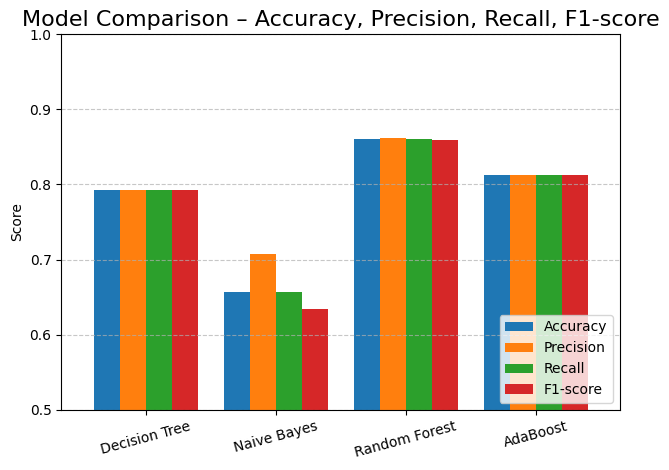

In [25]:
# Plot model comparison
plt.figure(figsize=(12, 7))
metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Comparison – Accuracy, Precision, Recall, F1-score', fontsize=16)
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=15)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

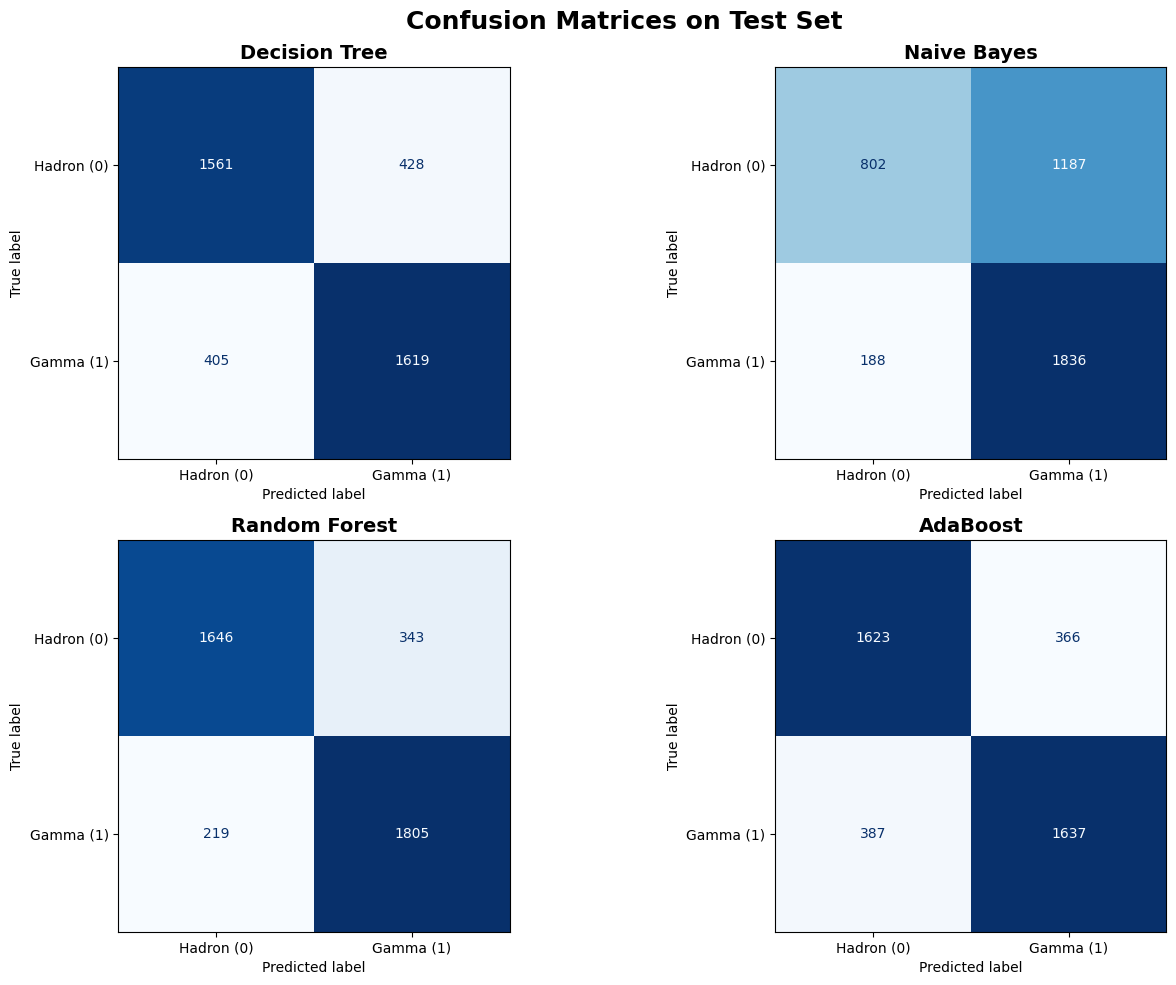

In [26]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hadron (0)', 'Gamma (1)'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{name}', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices on Test Set', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [27]:
# Display final results
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

for name in models.keys():
    print(f"\n{name}")
    print("-" * 30)
    for metric, value in metrics[name].items():
        print(f"  {metric}: {value:.4f}")

print("\n" + "="*50)
print("BEST MODEL PER METRIC:")
print("="*50)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    best_model = metrics_df[metric].idxmax()
    best_score = metrics_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.4f})")


FINAL RESULTS SUMMARY

Decision Tree
------------------------------
  Accuracy: 0.7924
  Precision: 0.7924
  Recall: 0.7924
  F1-score: 0.7924

Naive Bayes
------------------------------
  Accuracy: 0.6574
  Precision: 0.7078
  Recall: 0.6574
  F1-score: 0.6338

Random Forest
------------------------------
  Accuracy: 0.8600
  Precision: 0.8613
  Recall: 0.8600
  F1-score: 0.8598

AdaBoost
------------------------------
  Accuracy: 0.8124
  Precision: 0.8124
  Recall: 0.8124
  F1-score: 0.8124

BEST MODEL PER METRIC:
Accuracy: Random Forest (0.8600)
Precision: Random Forest (0.8613)
Recall: Random Forest (0.8600)
F1-score: Random Forest (0.8598)
